
<img src="https://www.continuum.io/sites/default/files/dask_stacked.png" alt="DASK logo" align="right" style="width: 200px;"/>

# DASK Tests
Dask: http://dask.pydata.org/en/latest/

Dask.distributed https://distributed.readthedocs.io/en/latest/





In [1]:
import dask
import distributed
import bokeh
import tornado
import numpy as np

## Versions

In [2]:
print('dask', dask.__version__)
print('distributed', distributed.__version__)
print('bokeh', bokeh.__version__ )
print('tornado', tornado.version)
print('numpy', np.__version__)

dask 0.14.1
distributed 1.16.1
bokeh 0.12.6
tornado 4.4.2
numpy 1.13.1


## Set up distributed workers

In [3]:
client = distributed.Client()
client

<Client: scheduler='tcp://127.0.0.1:56119' processes=4 cores=4>

## Example

In [4]:
import dask.array as da
import dask.dot

In [5]:
A = da.random.random(100, chunks=(25,))
A

dask.array<da.random.random_sample, shape=(100,), dtype=float64, chunksize=(25,)>

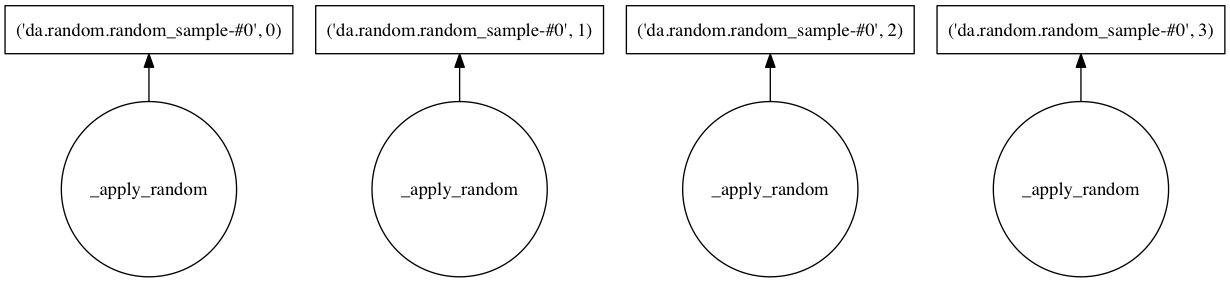

In [6]:
dask.dot.dot_graph(A.dask)

In [7]:
M = A.mean()
M

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>

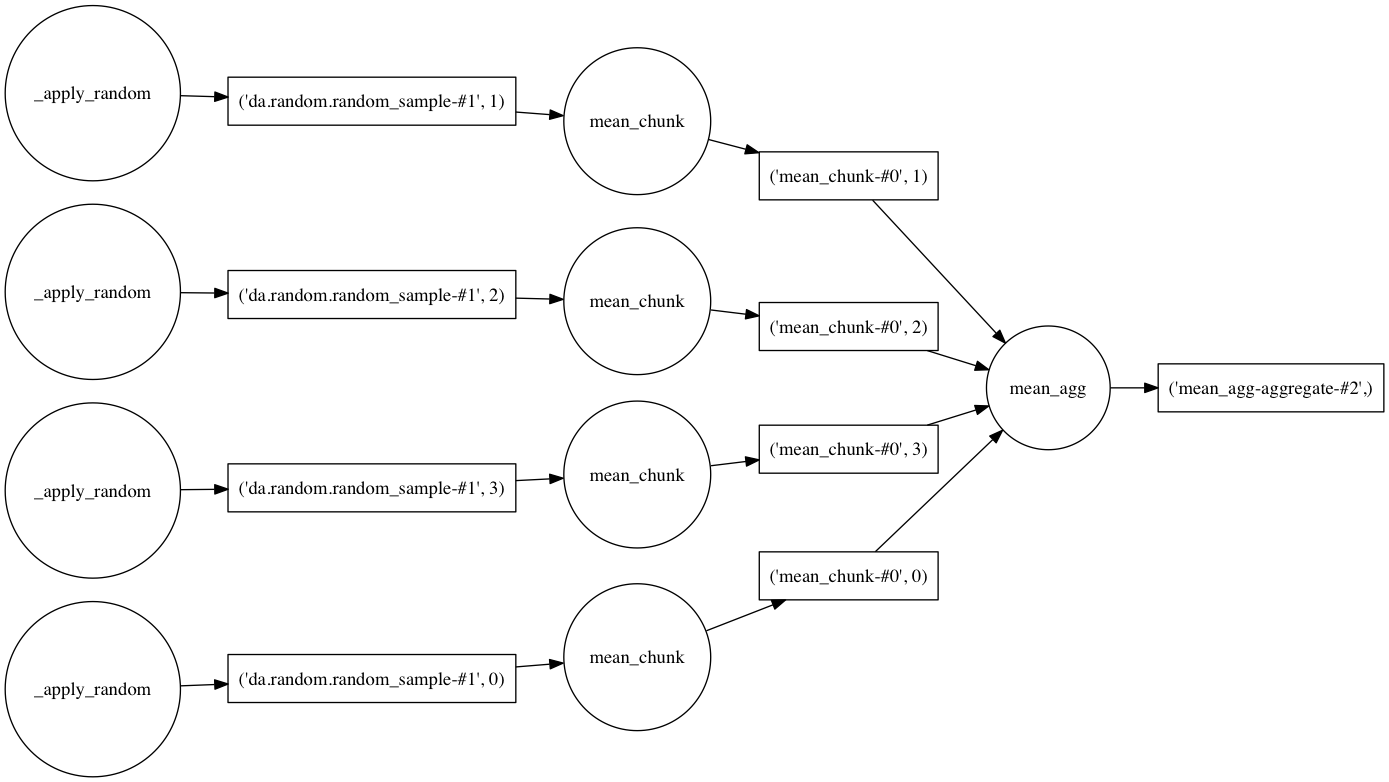

In [8]:
dask.dot.dot_graph(M.dask, rankdir='LR')

In [9]:
M.compute()

0.48180468524722825

In [10]:
from distributed.diagnostics import progressbar

In [11]:
A = da.random.random(100000, chunks=(25,))
M = A.mean()

In [14]:
f = client.compute(M)

In [15]:
progressbar.progress(f, multi=False)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [93]:
f = client.compute(M)
f

<Future: status: finished, type: float64, key: finalize-c408f57d679bc423fe7b50101085bec2>

In [94]:
progressbar.progress(f)